In [2]:
from __future__ import print_function, division
from builtins import range
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

In [3]:
#Environment
class Grid:
    def __init__(self, width, height, start):
        self.width = width
        self.height = height
        self.i = start[0]
        self.j = start[1]
        
    def set(self, rewards, actions):
        self.rewards = rewards
        self.actions = actions
        
    def set_state(self, state):
        self.i = state[0]
        self.j = state[1]
        
    def current_state(self):
        return(self.i, self.j)

    def is_terminal(self, s):
        return s not in self.actions 
    
    def move(self, action):
        if action in self.actions[(self.i, self.j)]:
            if action == 'U':
                self.i -= 1
            elif action =='D':
                self.i += 1
            elif action == 'R':
                self.j += 1
            elif action == 'L':
                self.j -= 1 
        
        return self.rewards.get((self.i, self.j), 0)
        
    
    def undo_move(self):
        if action == 'U':
            self.i += 1
        elif action =='D':
            self.i -= 1
        elif action == 'R':
            self.j -= 1
        elif action == 'L':
            self.j += 1 
        
        assert(self.current_state() in self.all_states())
                
            
    def game_over(self):
        return (self.i, self.j) not in self.actions
    
    
    def all_states(self):
        return set().union(self.actions.keys(), self.rewards.keys())

    

In [4]:
def standard_grid():
    # .  .  .  1
    # .  x  .  -1
    # s  .  .  .
    
    # 1, -1 are rewards for the corresponding positions
    # 'x'  not allowed
    # 's'  start state
    grid = Grid(3, 4, (2,0))
    rewards = {(0,3) : 1, (1,3) : -1}
    actions = {
        (0, 0): ('D', 'R'),
        (0, 1): ('L', 'R'),
        (0, 2): ('L', 'D', 'R'),
        (1, 0): ('U', 'D'),
        (1, 2): ('U', 'D', 'R'),
        (2, 0): ('U', 'R'),
        (2, 1): ('L', 'R'),
        (2, 2): ('L', 'R', 'U'),
        (2, 3): ('L', 'U'),
    }
    grid.set(rewards, actions)
    return grid

In [5]:
def negative_grid(step_cost=-0.1):
    grid = standard_grid()
    grid.rewards.update({
            (0, 0): step_cost,
            (0, 1): step_cost,
            (0, 2): step_cost,
            (1, 0): step_cost,
            (1, 2): step_cost,
            (2, 0): step_cost,
            (2, 1): step_cost,
            (2, 2): step_cost,
            (2, 3): step_cost,
    })
    return grid

In [6]:
def print_values(V, grid):
    for i in range(grid.width):
        print("---------------------------")
        for j in range(grid.height):
            v = V.get((i,j), 0)
            if v >= 0:
                print(" %.2f|" % v, end="")
            else:
                print("%.2f|" % v, end="") 
        print("")

In [7]:
def print_policy(P, grid):
    for i in range(grid.width):
        print("---------------------------")
        for j in range(grid.height):
            a = P.get((i,j), ' ')
            print("  %s  |" % a, end="")
        print("")

In [8]:
GAMMA = 0.9
POSSIBLE_ACTIONS  = ('U','D','L','R') 

In [9]:
def max_value_action(d):    

    max_key = None
    max_value = float('-inf')
    for k,v in d.items():
        if v > max_value :
            max_value = v
            max_key = k
    return max_key,max_value

In [13]:
def random_action(a, eps=0.1):
    p =  np.random.random()
    if p < eps:
        return np.random.choice(POSSIBLE_ACTIONS)
    else:
        return a

In [14]:
def play_grid_world(grid, policy):
        
    s = (2,0)
    grid.set_state(s)
    a = random_action(policy[s])
    
    states_actions_rewards = [(s, a, 0)]

    #play the game and capture the reward
    while True:
        r = grid.move(a)
        s = grid.current_state()

        if grid.game_over():
            states_actions_rewards.append((s,None,r))
            break
        else:
            a = random_action(policy[s])
            states_actions_rewards.append((s, a, r))

            
    # calculate returns
    G = 0
    states_actions_returns = []
    first = True
    for s, a, r in reversed(states_actions_rewards):
        if first:
            first = False
        else:
            states_actions_returns.append((s,a,G))
        G = r + GAMMA * G
    states_actions_returns.reverse()
    return states_actions_returns

rewards:
---------------------------
-0.10|-0.10|-0.10| 1.00|
---------------------------
-0.10| 0.00|-0.10|-1.00|
---------------------------
-0.10|-0.10|-0.10|-0.10|
0
1000
2000
3000
4000


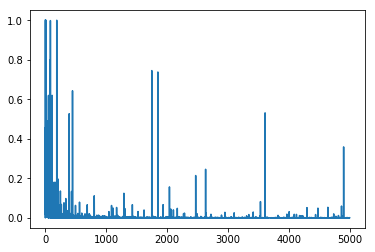


final policy:
---------------------------
  R  |  R  |  R  |     |
---------------------------
  D  |     |  U  |     |
---------------------------
  R  |  R  |  U  |  L  |

final values:
---------------------------
 0.25| 0.77| 1.00| 0.00|
---------------------------
 0.07| 0.00| 0.78| 0.00|
---------------------------
 0.22| 0.37| 0.55| 0.38|


In [17]:
if __name__ == '__main__':

    #grid = standard_grid()
    grid = negative_grid(step_cost=-0.1)

    # print rewards
    print("rewards:")
    print_values(grid.rewards, grid)

    # initialize a random policy
    policy = {}
    for s in grid.actions.keys():
        policy[s] = np.random.choice(POSSIBLE_ACTIONS)


    # initialize Q(s,a) and returns
    Q = {}
    returns = {} 
    states = grid.all_states()

    for s in states:
        if s in grid.actions: 
            Q[s] = {}
            for a in POSSIBLE_ACTIONS:
                Q[s][a] = 0 
                returns[(s,a)] = []
        else:
            pass

    deltas = []
    for t in range(5000):
        if t % 1000 == 0:
            print(t)

        biggest_change = 0
        states_actions_returns = play_grid_world(grid, policy)
        seen_state_action_pairs = set()

        for s, a, G in states_actions_returns:
            sa = (s, a)
            if sa not in seen_state_action_pairs:
                old_q = Q[s][a]
                returns[sa].append(G)
                Q[s][a] = np.mean(returns[sa])
                biggest_change = max(biggest_change, np.abs(old_q - Q[s][a]))
                seen_state_action_pairs.add(sa)

        deltas.append(biggest_change)
        
        # update policy
        for s in policy.keys():
            policy[s] = max_value_action(Q[s])[0]

    plt.plot(deltas)
    plt.show()


    print("\nfinal policy:")
    print_policy(policy, grid)


    # find V
    V = {}
    for s, Qs in Q.items():
        V[s] = max_value_action(Q[s])[1]


    print("\nfinal values:")
    print_values(V, grid)